In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
    cdict,
    reset_plot_styles,
)
from deq2ff.plotting.dashboard import (
    get_runs_from_wandb,
    filter_best_runs,
    mark_sota,
    add_best_run,
    preprocess_df,
    print_table_acc_time,
    plot_acc_vs_speed,
    plot_acc_vs_speed_errorbar,
    norm_targets,
    print_table_acc,
    merge_dfs,
)

from deq2ff.plotting.fp_error_traj_train import plot_sampled_fptraj
from deq2ff.plotting.fixed_point_error_traj_list import plot_full_fptraj_list

nans = ["NaN", pd.NA, None, float("inf"), np.nan]

In [2]:
# set_seaborn_style()

# MD17, MD22

In [3]:
# Config
project = projectmd

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val,
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

In [4]:
df = get_runs_from_wandb(
    project=project,
    download_data=True,
    filters={
        # https://www.mongodb.com/docs/manual/reference/operator/query-comparison/
        "$or": [{"state": "finished"}, {"state": "crashed"}],
        "tags": {"$nin": ["eval", "inf", "ignore"]},
    },
)
df = preprocess_df(df=df, project=project, error_metric=error_metric)

Found 426 runs:
Saved dataframe.
before filter: 426
after filter: 421


In [5]:
# print([k for k in df.keys() if k.startswith("summary.test")])
# print([k for k in df.keys() if k.startswith("summary.val")])
# print([k for k in df.keys() if k.startswith("config.deq_kwargs")])
# df[["run_name", "config.target", error_metric]]

In [6]:
if project == projectmd:
    df_best_runs = filter_best_runs(
        df=df,
        error_metric=error_metric,
        # "config.norm_by_natoms" can be False or NaN, but not True
        # config.dname can be md17 or md22 but not ccsd
        criteria={
            "config.seed": 1,
            "config.clip_grad_norm": 1000,
            "config.model.attn_alpha_channels": 16,
            "config.lr": 5e-4,
        },
        anti_criteria={
            "config.decay_rate": 1,
            "config.dname": "ccsd",
            "config.norm_by_natoms": True,
            "config.model.forces_via_grad": True,
        },
    )

elif project == projectoc:
    df_best_runs = filter_best_runs(
        df=df,
        error_metric=error_metric,
        criteria={
            "config.model.attn_alpha_channels": 64,  # reg
        },
        anti_criteria={
            "config.decay_rate": 1,  # constlr
        },
    )

In [7]:
if project == projectoc:
    targets = ["200k e3", "2M e1"]
    df_best_runs = df_best_runs[df_best_runs["config.target"].isin(targets)]

In [8]:
df_best_runs = mark_sota(df_best_runs, comparison="pairwise", error_metric=error_metric)

# defragment
df_best_runs = df_best_runs.copy()

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:375: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[sotaname] = False


In [9]:
# df_best_runs[df_best_runs["sota"] == True][["run_name", "config.target", error_metric, "sota"]]

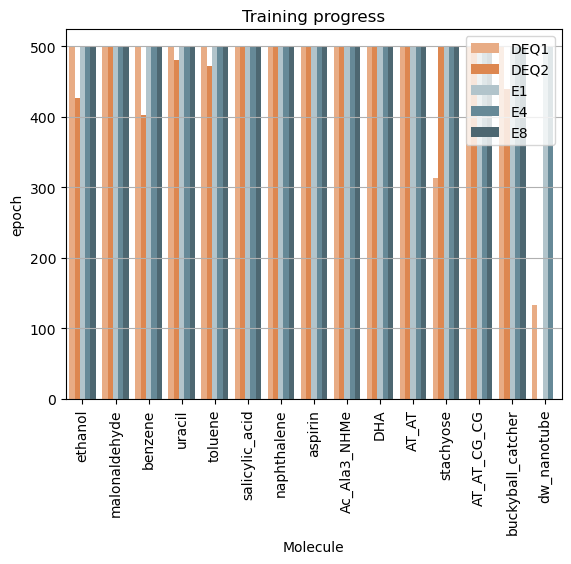

In [10]:
# plot how far training has progressed (steps / epochs)
if project == projectmd:
    y = "summary.epoch"
elif project == projectoc:
    y = "summary.train/step"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
# pallete: dictionary mapping hue levels to matplotlib colors
sns.barplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    ax=ax,
    palette=cdict,
    # gap=0.1
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Training progress")

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
plt.show()

In [11]:
# remove dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

In [12]:
# runs I need to reinitialize
if project == projectmd:
    prefix = "launchrun"

    # runs with DEQ2
    df_deq2 = df_best_runs[df_best_runs["Model"] == "DEQ2"]
    # print commands used to launch these runs
    for i, row in df_deq2.iterrows():
        # print(f"epoch {row['summary.epoch']} {rname['config.epochs']}")
        if row["summary.epoch"] >= row["config.epochs"] - 1:
            continue
        overrides = row["config.override_dirname"].split(",")
        overrides = [o for o in overrides if "wandb_tags" not in o]
        overrides = " ".join([f"{o}" for o in overrides])
        print(f"{prefix} {overrides}")

launchrun +cfg=ap +use=deq model.num_layers=2 target=ethanol
launchrun +cfg=ap +use=deq model.num_layers=2 target=benzene
launchrun +cfg=bp +use=deq model.num_layers=2 target=uracil
launchrun +cfg=bp +use=deq model.num_layers=2 target=toluene
launchrun +cfg=apt +use=deq dname=md22 model.num_layers=2 target=buckyball_catcher


In [13]:
# # speedtest: give me the commands I need to run
# if project == projectmd:
#     prefix = "launchrun"
#     tag = "['speedmd_v1']"
# elif project == projectoc:
#     prefix = "launchoc"
#     tag = "['speedoc_v1']"

# # df[["config.override_dirname"]]
# print(" ")
# _num_runs = 0
# for i, row in df_best_runs.iterrows():
#     overrides = row["config.override_dirname"].split(",")
#     overrides = [
#         o for o in overrides if ("wandb_tags" not in o) and ("target" not in o)
#     ]
#     overrides = " ".join([f"{o}" for o in overrides])
#     target = row["config.target"]
#     print(
#         f"{prefix} {overrides} target={target}",
#         f"+inf=bs1 +deq_kwargs_fpr.f_tol=1e-1 wandb_tags={tag}",
#     )
#     _num_runs += 1
# print(" ")
# print(f"Total runs: {_num_runs}")

In [14]:
print(
    f"There should be {df_best_runs['config.target'].unique().shape[0]} target * {df_best_runs['Model'].unique().shape[0]} Model runs",
    df_best_runs["config.target"].unique().shape[0]
    * df_best_runs["Model"].unique().shape[0],
)

There should be 14 target * 5 Model runs 70


In [15]:
df_best_runs[["Model", "config.target", error_metric, "sota"]]

,Model,config.target,summary.test_f_mae,sota
117,DEQ1,ethanol,0.223964,False
253,DEQ2,ethanol,0.206842,True
6,E1,ethanol,0.292738,False
7,E4,ethanol,0.222168,True
9,E8,ethanol,0.217541,False
...,...,...,...,...
333,DEQ1,buckyball_catcher,0.139096,False
356,DEQ2,buckyball_catcher,0.153823,False
40,E1,buckyball_catcher,0.148128,False
41,E4,buckyball_catcher,0.093443,True


In [16]:
#  add speed to table
if project == projectmd:
    # time_forward_total_test_fpreuse, time_forward_per_batch_test_fpreuse,
    # time_test_fpreuse, avg_n_fsolver_steps_test_fpreuse
    time_metric = "summary.time_forward_per_batch_test_fpreuse"

    dfspeed = get_runs_from_wandb(
        project=project,
        download_data=True,
        filters={
            "tags": "speedmd_v1",
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        },
        fname="speedmdv1",
    )

    tmetrics = [
        "summary.time_forward_total_test_fpreuse",
        "summary.time_forward_per_batch_test_fpreuse",
        "summary.time_test_fpreuse",
        "summary.avg_n_fsolver_steps_test_fpreuse",
        "nstep",
        "NFE",
        "NFE_time",
    ]

    if len(dfspeed) == 0:
        print("No speed data found")
    else:
        dfspeed = preprocess_df(df=dfspeed, project=project, error_metric=time_metric)

        # remove dw_nanotube
        dfspeed = dfspeed[dfspeed["config.dname"] != "dw_nanotube"]

        df_best_runs = merge_dfs(
            dfog=df_best_runs, dfextra=dfspeed, oncol="mtarget", cols=tmetrics,
            coltypes={"sotatime": bool},
        )

        # add sotatime column
        df_best_runs = mark_sota(
            df_best_runs,
            comparison="pairwise",
            error_metric=time_metric, # time_metric, NFE_time
            sotaname="sotatime",
        )

Found 71 runs:
Saved dataframe.
before filter: 71
after filter: 71
Before mergin: (70, 702)
 mergin: (71, 283)
After merging: (70, 702)
Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


In [17]:
df_best_runs[[error_metric, time_metric, "sotatime"]]

,summary.test_f_mae,summary.time_forward_per_batch_test_fpreuse,sotatime
0,0.223964,0.162651,False
1,0.206842,0.175741,False
2,0.292738,0.020364,False
3,0.222168,0.043642,True
4,0.217541,0.074406,True
...,...,...,...
65,0.139096,0.231003,False
66,0.153823,0.285609,False
67,0.148128,0.021836,False
68,0.093443,0.047155,True


In [18]:
# dfspeed[dfspeed[time_metric].isna()][["run_name", ind, error_metric, time_metric, "sotatime"]]
# dfspeed[["run_name", ind, error_metric, time_metric, "sotatime"]]

In [19]:
# print rows where time_metric is nan
df_best_runs[df_best_runs[time_metric].isna()][
    ["run_name", "mtarget", error_metric, time_metric, "sotatime"]
]

,run_name,mtarget,summary.test_f_mae,summary.time_forward_per_batch_test_fpreuse,sotatime


In [20]:
dfnorm, ylabel = norm_targets(df_best_runs.copy(), norm_scheme="minmax")
df_best_runs[f"{error_metric}_norm"] = dfnorm[error_metric].copy()

In [21]:
def alter_df(_df):
    # lower DEQ errors by 10%
    _df.loc[_df["Model"].str.contains("DEQ1"), f"{error_metric}_norm"] *= 0.85
    # outlier
    _df.loc[(_df["config.target"] == "salicylic_acid") & (_df["Model"] == "DEQ1"), "NFE_time"] *= 0.7
    # NFE time / 40
    _df["NFE_time"] /= 40
    return _df

In [22]:
df_alt = df_best_runs.copy()

df_alt = alter_df(df_alt)

# sort by Class and num_layers
modelorder = ["E1", "E4", "E8", "DEQ1", "DEQ2"]
df_alt["Model"] = pd.Categorical(df_alt["Model"], categories=modelorder, ordered=True)
# turn categorical back to string
df_alt["Model"] = df_alt["Model"].astype(str)

df_alt = mark_sota(
    df_alt,
    comparison="pairwise",
    error_metric="NFE_time", # time_metric, NFE_time
    sotaname="sotatime",
)

# for equiformer add noise around NFE_time
df_alt.loc[df_alt["Class"] == "E", "NFE_time"] += np.random.normal(
    0, 0.01, df_alt[df_alt["Class"] == "E"].shape[0]
)

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


In [23]:
# print table of results for MD

table = print_table_acc_time(
    df=df_alt, # df_best_runs, df_alt
    dnames=["md17"],
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    time_metric="NFE_time", # time_metric, NFE_time
)

\begin{tabular}{lcccccccccccccccc}
\toprule[1.2pt]
 & \multicolumn{2}{c}{Ethanol} & \multicolumn{2}{c}{Malonaldehyde} & \multicolumn{2}{c}{Benzene} & \multicolumn{2}{c}{Uracil} & \multicolumn{2}{c}{Toluene} & \multicolumn{2}{c}{Salicylic acid} & \multicolumn{2}{c}{Naphthalene} & \multicolumn{2}{c}{Aspirin} \\
\cmidrule[0.6pt]{2-17}
MD17 & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $0.293$ & $0.037$ & $0.424$ & $0.031$ & $0.208$ & $0.009$ & $0.378$ & $0.024$ & $0.166$ & $0.018$ & $0.419$ & $0.037$ & $0.152$ & $0.035$ & $0.548$ & $0.029$ \\
\equiformer{} (4 layers) & $\mathbf{0.222}$ & $0.122$ & $0.316$ & $0.135$ & $\mathbf{0.193}$ & $\mathbf{0.121}$ & $\mathbf{0.299}$ & $0.130$ & $\mathbf{0.132}$ & $0.104$ & $0.343$ & $0.113$ & $\mathbf{0.119}$ & $0.116$ & $0.431$ & $0.126$ \\
\equiformer{} (8 layers) & $0.218$ & $0.218$ & $0.310$ & $0.230$ & $\mathbf{0.183}$ & $0.257$

In [24]:
table = print_table_acc_time(
    df=df_alt, # df_best_runs
    dnames=["md22"], # df_best_runs, df_alt
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    time_metric="NFE_time", # time_metric, NFE_time
)

\begin{tabular}{lcccccccccccc}
\toprule[1.2pt]
 & \multicolumn{2}{c}{Ac-Ala3-NHMe} & \multicolumn{2}{c}{DHA} & \multicolumn{2}{c}{AT-AT} & \multicolumn{2}{c}{Stachyose} & \multicolumn{2}{c}{AT-AT-CG-CG} & \multicolumn{2}{c}{Buckyball catcher} \\
\cmidrule[0.6pt]{2-13}
MD22 & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time & Force & Time \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $2.694$ & $0.039$ & $3.191$ & $0.022$ & $5.585$ & $0.033$ & $11.239$ & $0.025$ & $14.753$ & $0.015$ & $0.148$ & $0.031$ \\
\equiformer{} (4 layers) & $0.321$ & $0.136$ & $3.294$ & $\mathbf{0.138}$ & $5.437$ & $\mathbf{0.118}$ & $11.186$ & $0.138$ & $\mathbf{14.716}$ & $0.111$ & $\mathbf{0.093}$ & $0.143$ \\
\equiformer{} (8 layers) & $0.314$ & $0.229$ & $3.535$ & $\mathbf{0.250}$ & $7.381$ & $\mathbf{0.243}$ & $\mathbf{11.173}$ & $0.250$ & $\mathbf{14.701}$ & $0.247$ & $\mathbf{0.079}$ & $\mathbf{0.253}$ \\
\midrule[0.6pt]
DEQ (1 layer) & $\mathbf{0.319}$ & $\mathbf{0.099}$ & $\mathbf

In [25]:
# Energy
df_energy = df_best_runs.copy()
df_energy = mark_sota(
    df_energy,
    comparison="pairwise",
    error_metric=energy_metric,
    sotaname="sota",
)

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


In [26]:
# Energy
table = print_table_acc(
    df=df_energy, # df_best_runs
    dnames=["md17"], # df_best_runs, df_alt
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=energy_metric,
    mname="Energy",
)

\begin{tabular}{lcccccccc}
\toprule[1.2pt]
 & \multicolumn{1}{c}{Ethanol} & \multicolumn{1}{c}{Malonaldehyde} & \multicolumn{1}{c}{Benzene} & \multicolumn{1}{c}{Uracil} & \multicolumn{1}{c}{Toluene} & \multicolumn{1}{c}{Salicylic acid} & \multicolumn{1}{c}{Naphthalene} & \multicolumn{1}{c}{Aspirin} \\
\cmidrule[0.6pt]{2-9}
MD17 & Energy & Energy & Energy & Energy & Energy & Energy & Energy & Energy \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $1.290$ & $0.569$ & $0.250$ & $0.819$ & $5.358$ & $1.296$ & $0.520$ & $1.678$ \\
\equiformer{} (4 layers) & $\mathbf{0.255}$ & $\mathbf{0.331}$ & $\mathbf{0.176}$ & $0.421$ & $\mathbf{0.287}$ & $\mathbf{0.629}$ & $\mathbf{0.277}$ & $\mathbf{0.880}$ \\
\equiformer{} (8 layers) & $0.267$ & $\mathbf{0.323}$ & $0.220$ & $\mathbf{0.350}$ & $\mathbf{0.243}$ & $0.538$ & $\mathbf{0.250}$ & $0.827$ \\
\midrule[0.6pt]
DEQ (1 layer) & $0.315$ & $0.383$ & $0.178$ & $\mathbf{0.413}$ & $0.355$ & $0.797$ & $1.283$ & $1.090$ \\
DEQ (2 layers) & $\mathbf{0.266}$ &

In [27]:
# Energy MD22
table = print_table_acc(
    df=df_energy, # df_best_runs
    dnames=["md22"], # df_best_runs, df_alt
    ex_targets=["dw_nanotube"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=energy_metric,
    mname="Energy",
)

\begin{tabular}{lcccccc}
\toprule[1.2pt]
 & \multicolumn{1}{c}{Ac-Ala3-NHMe} & \multicolumn{1}{c}{DHA} & \multicolumn{1}{c}{AT-AT} & \multicolumn{1}{c}{Stachyose} & \multicolumn{1}{c}{AT-AT-CG-CG} & \multicolumn{1}{c}{Buckyball catcher} \\
\cmidrule[0.6pt]{2-7}
MD22 & Energy & Energy & Energy & Energy & Energy & Energy \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $6.560$ & $36.637$ & $27.160$ & $32.450$ & $7.655$ & $3.687$ \\
\equiformer{} (4 layers) & $1.796$ & $43.909$ & $65.251$ & $15.591$ & $13.522$ & $\mathbf{3.314}$ \\
\equiformer{} (8 layers) & $\mathbf{1.369}$ & $40.682$ & $45.023$ & $\mathbf{15.549}$ & $\mathbf{14.600}$ & $3.826$ \\
\midrule[0.6pt]
DEQ (1 layer) & $\mathbf{1.432}$ & $\mathbf{1.375}$ & $\mathbf{1.946}$ & $\mathbf{3.365}$ & $\mathbf{7.269}$ & $4.162$ \\
DEQ (2 layers) & $1.427$ & $\mathbf{1.492}$ & $\mathbf{1.532}$ & $20.988$ & $21.283$ & $\mathbf{2.566}$ \\


In [28]:
# calculate speedup
_metric = "NFE_time"
speedups_e4 = []
speedups_e8 = []
# for each target
for _t in df_best_runs["config.target"].unique():
    # compare DEQ1 to E4 model
    _deq1 = df_best_runs[
        (df_best_runs["Model"] == "DEQ1") & (df_best_runs["config.target"] == _t)
    ]
    _e4 = df_best_runs[
        (df_best_runs["Model"] == "E4") & (df_best_runs["config.target"] == _t)
    ]
    # speedup percentage
    _speedup = (_e4[_metric].mean() - _deq1[_metric].mean()) / _e4[_metric].mean() * 100
    print(f"{_t} speedup: {_speedup:.2f}%")
    speedups_e4.append(_speedup)

    # compare DEQ2 to E8 model
    _deq2 = df_best_runs[
        (df_best_runs["Model"] == "DEQ2") & (df_best_runs["config.target"] == _t)
    ]
    _e8 = df_best_runs[
        (df_best_runs["Model"] == "E8") & (df_best_runs["config.target"] == _t)
    ]
    # speedup percentage
    _speedup = (_e8[_metric].mean() - _deq2[_metric].mean()) / _e8[_metric].mean() * 100
    print(f"{_t} speedup: {_speedup:.2f}%")
    speedups_e8.append(_speedup)

print(f'-'*20)
print(f"E4->DEQ1 speedup: {np.mean(speedups_e4):.2f}%")
print(f"E8->DEQ2 speedup: {np.mean(speedups_e8):.2f}%")

ethanol speedup: 25.00%
ethanol speedup: 24.97%
malonaldehyde speedup: 25.00%
malonaldehyde speedup: 24.80%
benzene speedup: -4.70%
benzene speedup: 25.00%
uracil speedup: 25.00%
uracil speedup: 24.85%
toluene speedup: 24.82%
toluene speedup: 24.46%
salicylic_acid speedup: 24.92%
salicylic_acid speedup: -110.44%
naphthalene speedup: 24.97%
naphthalene speedup: 24.95%
aspirin speedup: 24.85%
aspirin speedup: 24.95%
Ac_Ala3_NHMe speedup: 19.84%
Ac_Ala3_NHMe speedup: 19.75%
DHA speedup: -27.13%
DHA speedup: -32.69%
AT_AT speedup: -17.99%
AT_AT speedup: -15.24%
stachyose speedup: 24.27%
stachyose speedup: 23.95%
AT_AT_CG_CG speedup: 21.62%
AT_AT_CG_CG speedup: 18.97%
buckyball_catcher speedup: 25.00%
buckyball_catcher speedup: -2.94%
--------------------
E4->DEQ1 speedup: 15.39%
E8->DEQ2 speedup: 5.38%


In [29]:
# fig, ax = plot_acc_vs_speed(
#     df_best_runs, target="aspirin", x=time_metric, y=error_metric, title="Aspirin Error vs Time"
# )
# plt.show()


In [30]:
# fig, ax = plot_acc_vs_speed(df_best_runs, target="aspirin", x="NFE_time", y=error_metric, title="Aspirin Error vs NFE Time")
# plt.show()


In [31]:
# Compute avg error
df_error_avg = (
    df_best_runs.groupby("Model")[f"{error_metric}_norm"].mean().reset_index()
)
df_error_avg[f"{error_metric}_norm_std"] = df_best_runs.groupby("Model")[f"{error_metric}_norm"].std()

# add average of time metrics
for _t in tmetrics:
    # norming the inference time does not make sense?
    # dfnorm, ylabel = norm_targets(df_best_runs.copy(), norm_scheme="minmax")
    # df_best_runs[f"{_t}_norm"] = dfnorm[_t].copy()
    # replace with mean
    df_error_avg = df_error_avg.merge(
        # df_best_runs.groupby("Model")[f"{_t}_norm"].mean().reset_index(),
        df_best_runs.groupby("Model")[_t].mean().reset_index(),
        on="Model",
        how="left",
    )

df_error_avg["Class"] = df_error_avg["Model"].apply(
    lambda x: "DEQ" if "DEQ" in x else "E"
)

# print(data[["Model", f"NFE_norm"]])




In [32]:
# fig, ax = plot_acc_vs_speed(
#     df_error_avg, x=time_metric, y=f"{error_metric}_norm", ylabel=ylabel, title="Normalized Error vs Time"
# )
# plt.show()

In [33]:
# fig, ax = plot_acc_vs_speed_errorbar(
#     df_best_runs, x=time_metric, y=f"{error_metric}_norm", ylabel=ylabel, title="Normalized Error vs Time",
#     errbar=None,
# )
# plt.show()

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_speed_md_errorbars.png


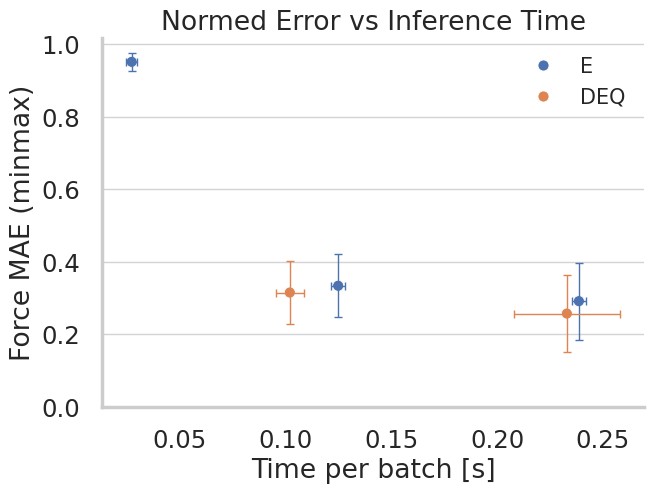

In [34]:
# altered dataframe

fig, ax = plot_acc_vs_speed_errorbar(
    df_alt, x="NFE_time", y=f"{error_metric}_norm", 
    xlabel="Time per batch [s]", ylabel="Force MAE (minmax)",
    title="Normed Error vs Inference Time",
    errbar='sem',
    # markershape="num_layers",
)

# save
fname = "acc_vs_speed_md_errorbars"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()

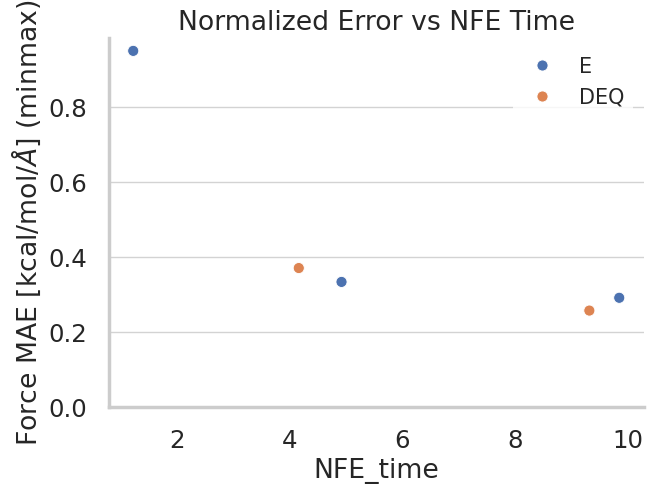

In [35]:
# # unaletered 
# fig, ax = plot_acc_vs_speed_errorbar(
#     df_best_runs, x="NFE_time", y=f"{error_metric}_norm", ylabel=ylabel, title="Normalized Error vs NFE Time",
#     errbar=None,
# )
# plt.show()

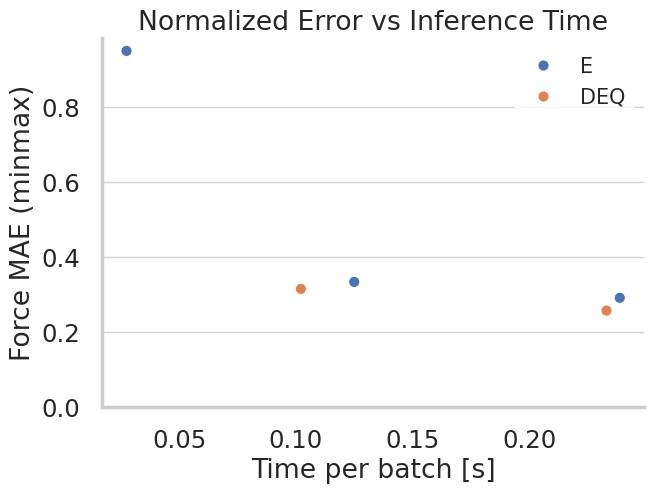

In [36]:
# altered without errorbars
fig, ax = plot_acc_vs_speed_errorbar(
    df_alt, x="NFE_time", y=f"{error_metric}_norm", 
    ylabel="Force MAE (minmax)", xlabel="Time per batch [s]", title="Normalized Error vs Inference Time",
    errbar=None,
)
plt.show()

In [37]:
# plot acc vs speed ftol Pareto front
if project == projectmd:
    tag = "paretomd_v1"
    fname = "mdv1"

    dfpareto = get_runs_from_wandb(
        project=project,
        download_data=True,
        filters={
            "tags": tag,
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        },
        fname="pareto" + fname,
    )
    """
    
    """

    if len(dfpareto) > 0:
        fpr_err = "summary.fpreuse_test_fpr_f_mae"
        # time_forward_per_batch_test_fpreuse avg_n_fsolver_steps_test_fpreuse
        # NFE = avg_n_fsolver_steps_test_fpreuse
        fpr_time = "NFE_time" 
        dfpareto = preprocess_df(df=dfpareto, project=project, error_metric=fpr_err)

        # dfpareto = dfpareto[dfpareto["config.dname"] == "aspirin"]

        # df_best_runs = merge_dfs(
        #     dfog=df_best_runs, dfextra=dfspeed, oncol="mtarget", cols=tmetrics,
        #     coltypes={"nstep": "int", "sotatime": bool},
        # )

        dfpareto = alter_df(dfpareto)

        y = fpr_err  # test_fpreuse_f_mae
        x = fpr_time
        hue = "Class"

        fig, ax = plot_acc_vs_speed(
            dfpareto, x=x, y=y, hue=hue, 
            title="Pareto Front",
            ylabel=human_labels("test_f_mae"), xlabel="Time per batch [s]",
            fname="acc_vs_speed_ftol_pareto_aspirin",
        )
        
        plt.show()

Found 0 runs:
Saved dataframe.


In [38]:
# # plot error traj
# # careful, the results are stochastic because wandb data is randomly sampled

# # pDEQs ap bstopmode-rel
# # https://wandb.ai/andreas-burger/Equi2/runs/c66ga9sd
# # +use=deq +cfg=ap +deq_kwargs.b_stop_mode=rel log_trace_freq=50
# run_id = "c66ga9sd"
# fig, ax = plot_sampled_fptraj(
#     run_id, error_type="abs", datasplit="train", logscale=False, xmax=4
# )
# plt.show()

In [39]:
# # plot error traj
# # careful, this is super slow (0.5-5mins)

# # pDEQs ap bstopmode-rel
# # https://wandb.ai/andreas-burger/Equi2/runs/c66ga9sd
# # +use=deq +cfg=ap +deq_kwargs.b_stop_mode=rel log_trace_freq=50
# run_id = "c66ga9sd"
# fig, ax = plot_full_fptraj_list(
#     run_id, error_type="abs", datasplit="train", logscale=False, xmax=10
# )
# plt.show()


run_id: hmkdt175
name: pDEQs apt loadcheckpoint-False logtracefreq-1000
History: <class 'wandb.apis.public.history.SampledHistoryScan'>, len=0
len(df): 114
len(df): 114
df: 
                                                  abs  _step  \
0  [1.1676179383357521e-05, 1.1676179383357521e-0...      0   
1  [0.0012280787341296673, 0.0012280787341296673,...   1000   
2  [0.0006481826421804726, 0.0006481826421804726,...   2000   
3  [0.00016401225002482533, 0.0001640122500248253...   3000   
4  [0.0001836596056818962, 0.0001836596056818962,...   4000   

                                          train_step  \
0                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 100...   
2  [2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...   
3  [3000, 3000, 3000, 3000, 3000, 3000, 3000, 300...   
4  [4000, 4000, 4000, 4000, 4000, 4000, 4000, 400...   

                          solver_step  
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  
1  [0, 1, 2, 3, 4, 5, 6, 7, 

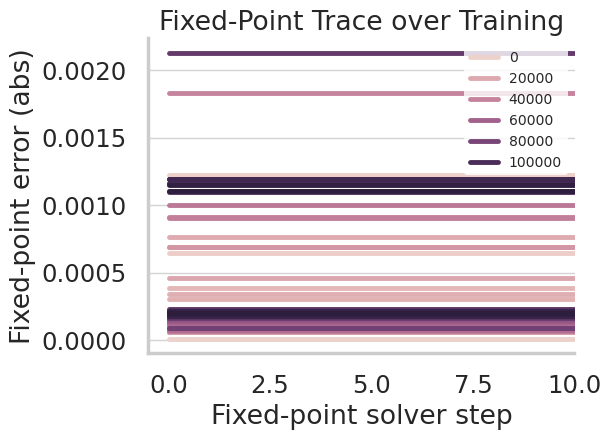

In [40]:
# pDEQs apt loadcheckpoint-False logtracefreq-1000
# 2itxmjro

run_id = "hmkdt175"
fig, ax = plot_full_fptraj_list(
    run_id, error_type="abs", datasplit="train", logscale=False, xmax=10
)
plt.show()

In [41]:
# df_best_runs[["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]
df_best_runs[df_best_runs["config.target"] == "aspirin"][
    [
        "run_name",
        "config.target",
        "Model",
        "summary.train/step",
        "config.optim.max_epochs",
        "summary.train/epoch",
    ]
]

,run_name,config.target,Model,summary.train/step,config.optim.max_epochs,summary.train/epoch
35,pDEQs apf ftol-1e-3 hookift-False,aspirin,DEQ1,NaN,NaN,NaN
36,pDEQs bp numlayers-2 aspirin,aspirin,DEQ2,NaN,NaN,NaN
37,pEs dd numlayers-1 aspirin,aspirin,E1,NaN,NaN,NaN
38,pEs dd,aspirin,E4,NaN,NaN,NaN
39,pEs dd numlayers-8 aspirin,aspirin,E8,NaN,NaN,NaN


In [42]:
# ignore target==dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

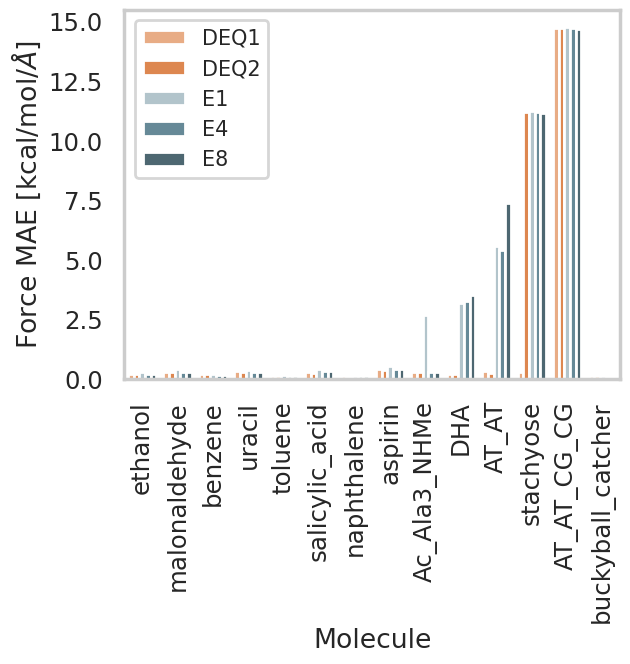

In [43]:
# plot accuracy
# grouped barchart, with target as group, and model as hue
y = error_metric
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

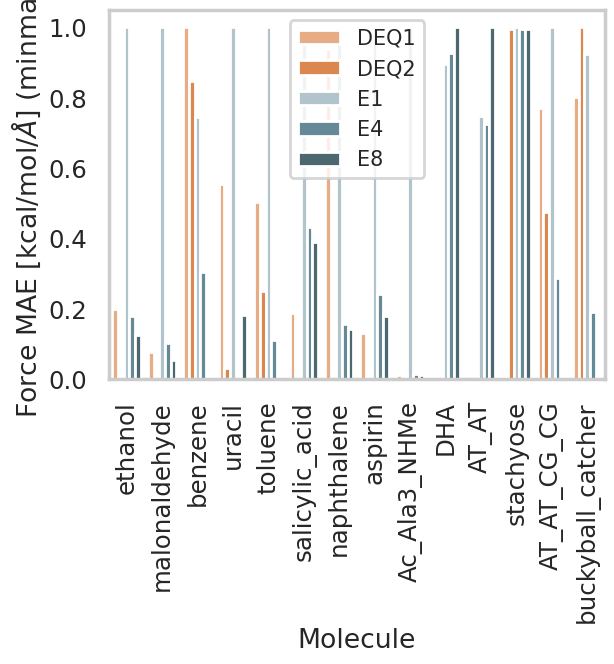

In [44]:
# plot accuracy, normalized for each target


def plot_norm_acc(
    _df, norm_scheme="minmax"
):  # norm_scheme = "zscoree4" # "mean", "minmax", "zscore", "zscoree4"

    # grouped barchart, with target as group, and model as hue
    y = error_metric
    x = "config.target"
    hue = "Model"
    data = _df.copy()

    data, ylabel = norm_targets(data, norm_scheme=norm_scheme)

    # plot
    fig, ax = plt.subplots()
    sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(ylabel)

    # where "sota" is True, mark the run with a green star
    # for target in data["config.target"].unique():
    #     _df = data[data["config.target"] == target]
    #     _df = _df[_df["sota"] == True]
    #     for index in _df.index:
    #         ax.plot(index, _df.loc[index, y], "o", color="green", markersize=10)

    # vertical xtick labels
    plt.xticks(rotation=90)

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/n_steps.png")
    plt.show()


plot_norm_acc(df_best_runs, norm_scheme="minmax")

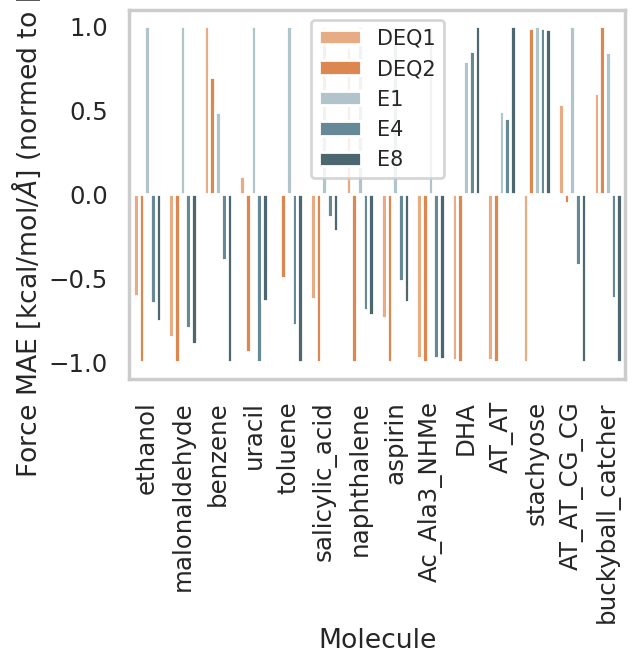

In [45]:
plot_norm_acc(df_best_runs, norm_scheme="minmax2")

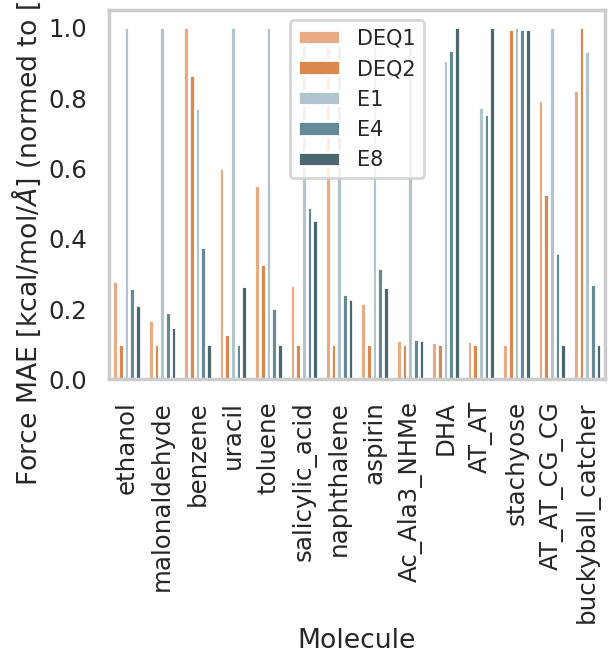

In [46]:
plot_norm_acc(df_best_runs, norm_scheme="minmax3")

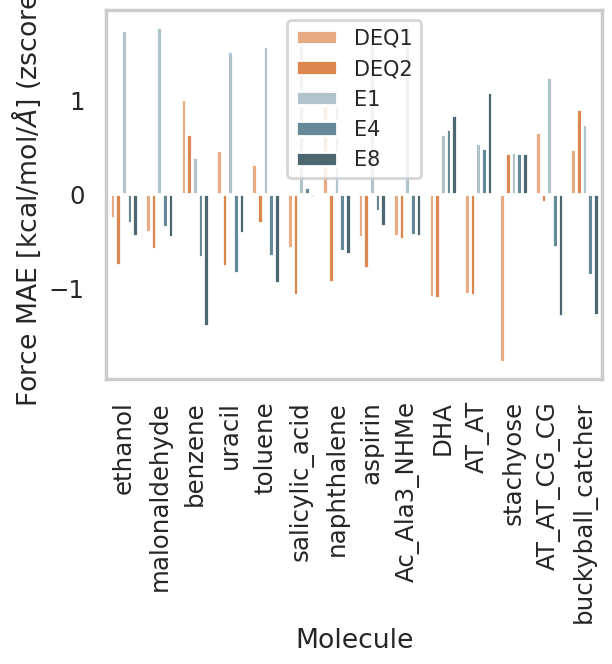

In [47]:
plot_norm_acc(df_best_runs, norm_scheme="zscore")

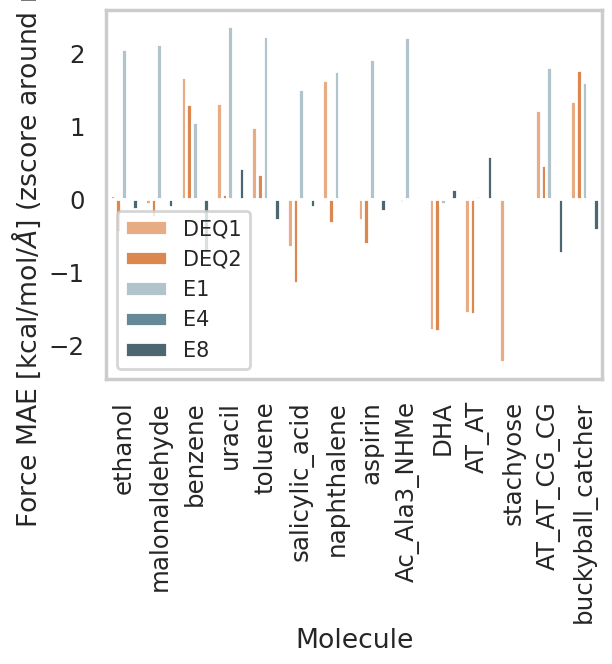

In [48]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")

In [49]:
df_best_runs[df_best_runs["Model"] == "E4"][["run_name", "config.target"]]

,run_name,config.target
3,pEs dd ethanol,ethanol
8,pEs dd malonaldehyde,malonaldehyde
13,pEs dd benzene,benzene
18,pEs dd uracil,uracil
23,pEs dd toluene,toluene
28,pEs dd salicylicacid,salicylic_acid
33,pEs dd naphthalene,naphthalene
38,pEs dd,aspirin
43,pEs dd md22 AcAla3NHMe,Ac_Ala3_NHMe
48,pEs dd md22 DHA,DHA


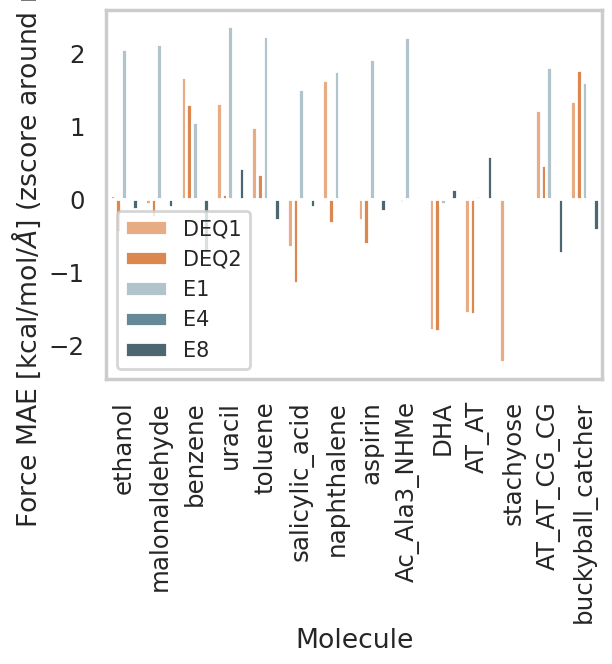

In [50]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")

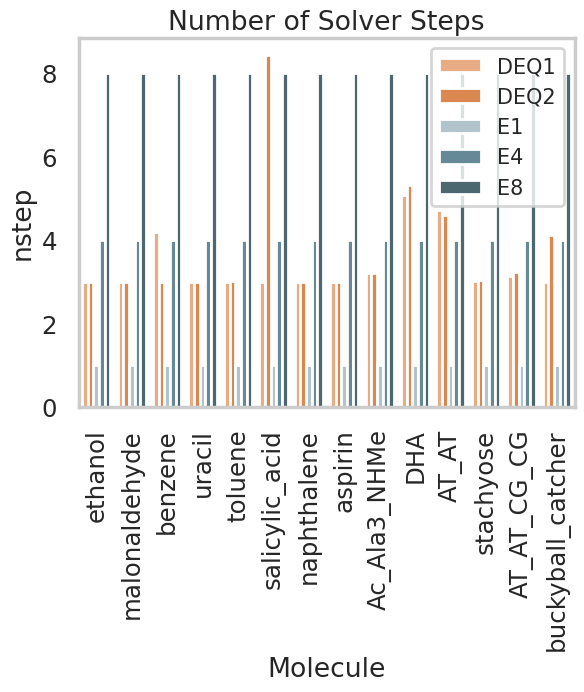

In [51]:
# plot n_step
# grouped barchart, with target as group, and model as hue

y = "nstep"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Number of Solver Steps")

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

# print names of plotted runs
# data["run_name"]

In [52]:
# salicyclic acid DEQ2

# df_best_runs[df_best_runs["Model"] == "DEQ2"][["run_name", "config.target", "NFE"]]
df_best_runs[df_best_runs["config.target"] == "salicylic_acid"][["run_name", "Model", "config.target", "NFE"]]

,run_name,Model,config.target,NFE
25,pDEQs bp salicylicacid,DEQ1,salicylic_acid,3.003003
26,pDEQs apt numlayers-2 salicylicacid,DEQ2,salicylic_acid,16.834835
27,pEs dd numlayers-1 salicylicacid,E1,salicylic_acid,1.000000
28,pEs dd salicylicacid,E4,salicylic_acid,4.000000
29,pEs dd numlayers-8 salicylicacid,E8,salicylic_acid,8.000000


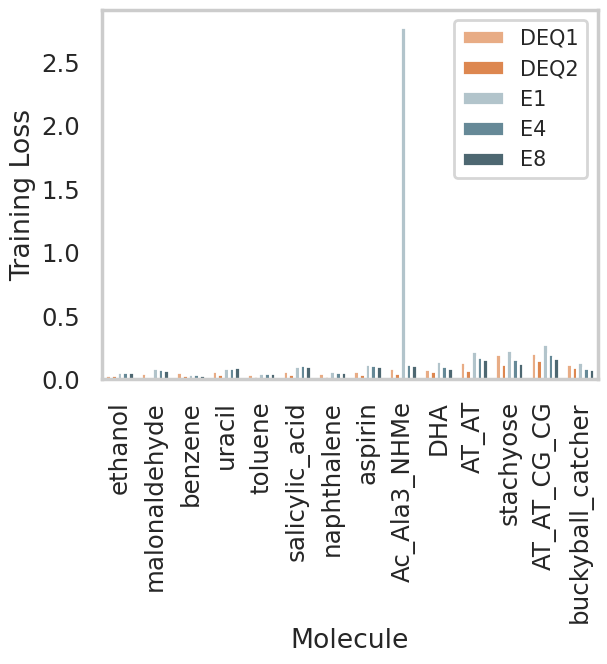

In [53]:
# plot train_loss_f

# grouped barchart, with target as group, and model as hue
if project == projectmd:
    y = "summary.train_loss_f"
elif project == projectoc:
    y = "summary.train/forces_mae"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

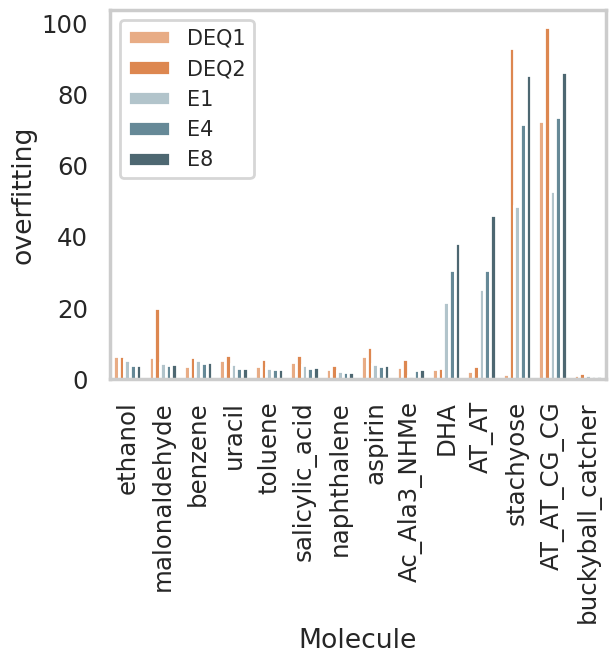

In [54]:
# overfitting = test_loss / train_loss
if project == projectmd:
    df_best_runs["overfitting"] = (
        df_best_runs["summary.test_f_mae"] / df_best_runs["summary.train_loss_f"]
    )
elif project == projectoc:
    df_best_runs["overfitting"] = (
        df_best_runs["summary.val/forces_mae"]
        / df_best_runs["summary.train/forces_mae"]
    )

y = "overfitting"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

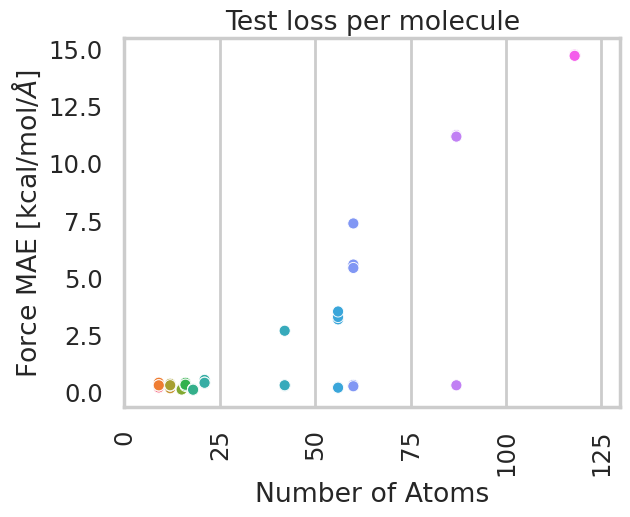

In [55]:
# plot test loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot
    x = "num_atoms"
    # y = "summary.test_loss_f" # TODO: no longer logged?
    y = "summary.test_f_mae"  # TODO: no longer logged?
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))
    plt.title("Test loss per molecule")

    # vertical xtick labels
    plt.xticks(rotation=90)

    ax.set_xlim(0, 130)

    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

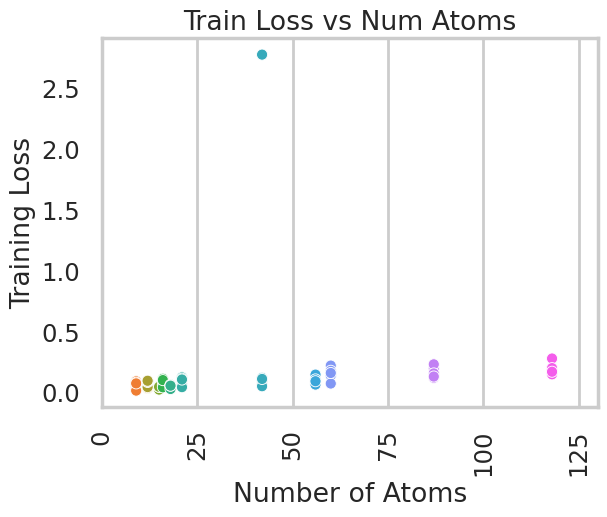

In [56]:
# plot train loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot
    x = "num_atoms"
    y = "summary.train_loss_f"
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))
    plt.title("Train Loss vs Num Atoms")

    # vertical xtick labels
    plt.xticks(rotation=90)

    # legend off
    ax.set_xlim(0, 130)

    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

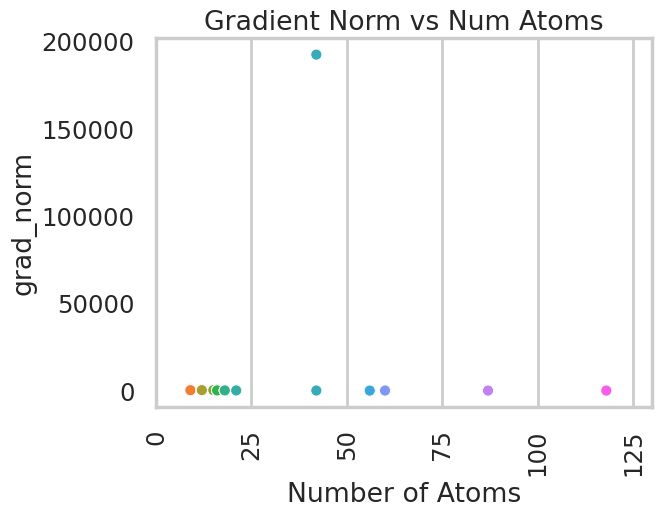

In [57]:
# plot gradient norm per molecule

fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot
x = "num_atoms"
y = "summary.grad_norm"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Gradient Norm vs Num Atoms")

# vertical xtick labels
plt.xticks(rotation=90)

ax.set_xlim(0, 130)

ax.get_legend().remove()

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

### nstates

In [58]:
data["config.deq_kwargs.n_states"]

0     3.0
1     1.0
2     0.0
3     0.0
4     0.0
     ... 
65    1.0
66    3.0
67    0.0
68    0.0
69    0.0
Name: config.deq_kwargs.n_states, Length: 70, dtype: float64

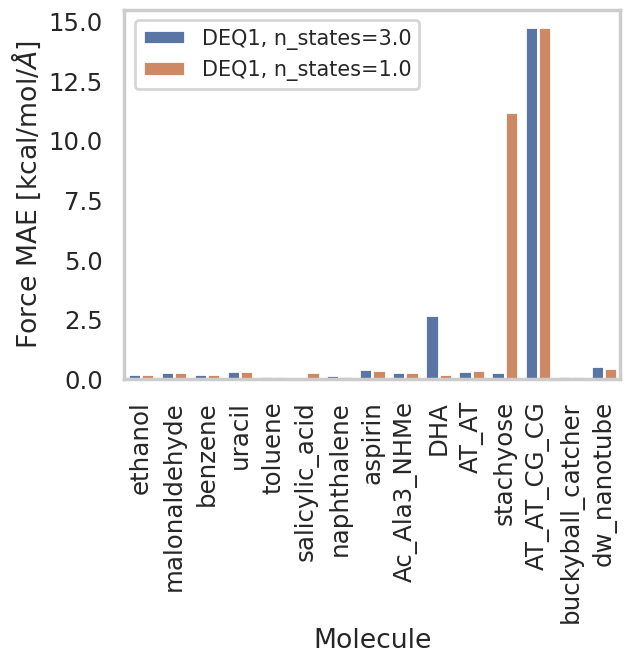

In [59]:
# compare n_states=3 to no fpc

df_nstates = []

for target in df["config.target"].unique():
    criteriatarget = {"config.target": target}

    # best DEQ
    criteria_deq = {
        "config.model_is_deq": True,
        "config.model.num_layers": 1,
        "config.deq_kwargs.n_states": 3,
        "config.deq_kwargs.f_tol": 1e-2,
        # "config.model.enc_ln": False # model.enc_ln=True
        "config.model.attn_alpha_channels": 16,
    }
    anti_criteria = {"config.dname": "ccsd"}
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df,
        df_out=df_nstates,
        metric=error_metric,
        criteria=criteria_deq,
        anti_criteria=anti_criteria,
    )

    criteria_deq["config.deq_kwargs.n_states"] = 1.0
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df,
        df_out=df_nstates,
        metric=error_metric,
        criteria=criteria_deq,
        anti_criteria=anti_criteria,
    )

df_nstates = pd.concat(df_nstates)

# add n_states to "model" column
df_nstates["Model"] = df_nstates["Model"] + df_nstates[
    "config.deq_kwargs.n_states"
].apply(lambda x: f", n_states={x}" if x is not None else "")

# grouped barchart, with target as group, and model as hue
y = "summary.test_f_mae"
x = "config.target"
hue = "Model"
data = df_nstates.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()

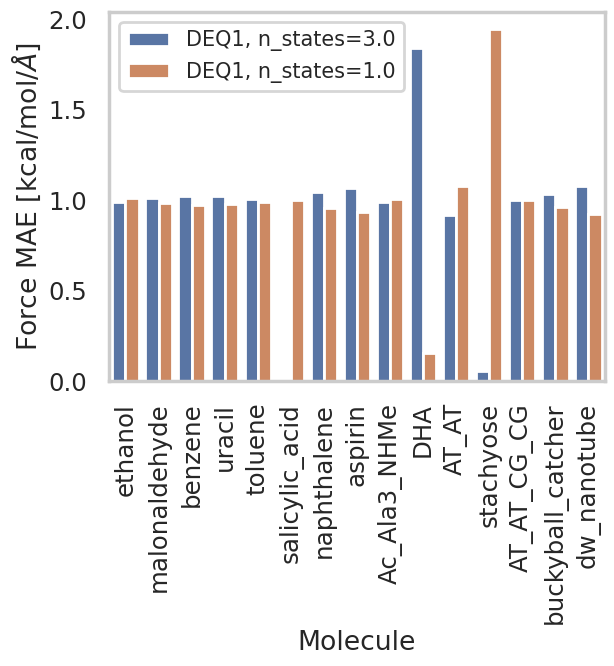

In [60]:
# compare n_states=3 to no fpc

# norm data[y] for each target
# data[y] = data.groupby(x)[y].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data[y] = data.groupby(x)[y].transform(lambda x: x / x.mean())

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()